# Advent of code 2015

[[**Open the notebook in Colab**]](https://colab.research.google.com/github/hhoppe/advent_of_code/blob/main/2015/advent_of_code_2015.ipynb)

Jupyter [notebook](https://github.com/hhoppe/advent_of_code/blob/main/2015/advent_of_code_2015.ipynb)
with Python solutions to the
[2015 Advent of Code puzzles](https://adventofcode.com/2015),
completed in April 2023,
by [Hugues Hoppe](https://hhoppe.com/).

The notebook presents both "compact" and "fast" code versions, along with data visualizations.

For the fast solutions, the [cumulative time](#timings) across all 25 puzzles is about 1 s on my PC.<br/>
(Some solutions use the `numba` package to jit-compile functions, which can take a few seconds.)<br/>

Here are some visualization results:

<p>
<a href="#day3">day3</a> <img src="results/day3.png" width="220"> &emsp;
<a href="#day6">day6</a> <img src="results/day6a.gif" width="220"> &nbsp;
  <img src="results/day6b.gif" width="220">
</p>

<p>
<a href="#day7">day7</a> <img src="results/day7.png" width="200"> &emsp;
<a href="#day14">day14</a> <img src="results/day14.gif" width="500">
</p>

<p>
<a href="#day18">day18</a> <img src="results/day18a.gif" width="180"> &nbsp;
  <img src="results/day18b.gif" width="180"> &emsp;
<a href="#day19">day19</a> <img src="results/day19.png" width="256">
</p>

<a name="preamble"></a>
## Preamble

In [1]:
!command -v ffmpeg >/dev/null || (apt-get -qq update && apt-get -qq -y install ffmpeg) >/dev/null  # For mediapy.

In [2]:
!dpkg -l | grep -q libgraphviz-dev || (apt-get -qq update && apt-get -qq -y install libgraphviz-dev) >/dev/null  # https://stackoverflow.com/a/66380001

In [3]:
!pip install -q advent-of-code-hhoppe hhoppe-tools matplotlib mediapy more-itertools \
  networkx numba numpy pygraphviz pyparsing

In [4]:
import ast
import collections
from collections.abc import Callable, Iterable, Iterator, Sequence
import dataclasses
import enum
import functools
import graphlib
import hashlib
import itertools
import json
import math
import multiprocessing
import operator
import pathlib
import random
import re
import subprocess
import sys
from typing import Any, TypeVar

import advent_of_code_hhoppe  # https://github.com/hhoppe/advent-of-code-hhoppe/blob/main/advent_of_code_hhoppe/__init__.py
import hhoppe_tools as hh  # https://github.com/hhoppe/hhoppe-tools/blob/main/hhoppe_tools/__init__.py
import matplotlib.pyplot as plt
import mediapy as media  # https://github.com/google/mediapy/blob/main/mediapy/__init__.py
import more_itertools
import networkx
import numba
import numpy as np
import pyparsing

In [5]:
# If run outside IPython, to enable 'spawn', instead launch a multiprocessing-safe main script.
if 'In' not in globals() and __name__ == '__main__':
  subprocess.run([sys.executable, __file__.replace('.py', '_run.py')], check=True)
  sys.exit()

In [6]:
if not media.video_is_available():
  media.show_videos = lambda *a, **kw: print('Creating video is unavailable.')

In [7]:
if pathlib.Path('results').is_dir():
  media.set_show_save_dir('results')

In [8]:
hh.start_timing_notebook_cells()

In [9]:
YEAR = 2015
PROFILE = 'google.Hugues_Hoppe.965276'
# PROFILE = 'github.hhoppe.1452460'
SHOW_BIG_MEDIA = hh.get_env_bool('SHOW_BIG_MEDIA')
# echo 53616... >~/.config/aocd/token  # session cookie from "adventofcode.com" (valid 1 month).

In [10]:
TAR_URL = f'https://github.com/hhoppe/advent_of_code/raw/main/{YEAR}/data/{PROFILE}.tar.gz'
advent = advent_of_code_hhoppe.Advent(year=YEAR, tar_url=TAR_URL)

In [11]:
hh.adjust_jupyterlab_markdown_width()

### Helper functions

In [12]:
check_eq = hh.check_eq

In [13]:
# CPython has two implementations of MD5 hashing (https://stackoverflow.com/a/60254866):
# - https://github.com/python/cpython/blob/main/Modules/_hashopenssl.c (hashlib) and
# - https://github.com/python/cpython/blob/main/Modules/md5module.c (_md5).
# # %timeit hashlib.md5(b'hello world')  # ~145 ns.
# # %timeit _md5.md5(b'hello world')  # ~55 ns.
def _get_md5() -> Any:
  try:
    import _md5  # pytype: disable=import-error

    return _md5.md5

  except ModuleNotFoundError:
    return hashlib.md5

In [14]:
_T = TypeVar('_T')

In [15]:
_ORIGINAL_GLOBALS = list(globals())

<a name="day1"></a>
## Day 1: Not quite lisp

- Part 1: To what floor do the instructions take Santa?

- Part 2: What is the position of the character that causes Santa to first enter the basement?

In [16]:
puzzle = advent.puzzle(day=1)

For [day 1](https://adventofcode.com/2015/day/1), `puzzle.input` has a single line of 7_000 characters:

()()(()()()(()()((()((()))((()((((()()((((()))()((((())(((((((()(((((((((()(((() ... ((()))()(()()((()()()()()())(((((((


The stored answers are: `{1: '280', 2: '1797'}`

In [17]:
def day1(s, *, part2=False):
  line = s.strip()

  if not part2:
    return line.count('(') - line.count(')')

  floor = 0
  for position, ch in enumerate(line, 1):
    floor += {'(': 1, ')': -1}[ch]
    if floor < 0:
      return position


check_eq(day1('(()(()('), 3)
check_eq(day1('))((((('), 3)
check_eq(day1('())'), -1)
check_eq(day1(')())())'), -3)
puzzle.verify(1, day1)

day1_part2 = functools.partial(day1, part2=True)
check_eq(day1_part2(')'), 1)
check_eq(day1_part2('()())'), 5)
puzzle.verify(2, day1_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day2"></a>
## Day 2: Wrapping presents

- Part 1: All numbers in the elves' list are in feet. How many total square feet of wrapping paper should they order?

- Part 2: How many total feet of ribbon should they order?

In [18]:
puzzle = advent.puzzle(day=2)

For [day 2](https://adventofcode.com/2015/day/2), `puzzle.input` has 1_000 lines:

20x3x11
15x27x5
6x29x7
30x15x9
19x29x21
10x4x15
1x26x4
1x5x18
 ...
10x1x18
29x4x8
21x2x22
14x12x8


The stored answers are: `{1: '1606483', 2: '3842356'}`

In [19]:
def day2(s, *, part2=False):
  lines = s.splitlines()
  sum_area = 0
  sum_ribbon = 0

  for line in lines:
    sides = list(map(int, line.split('x')))
    assert len(sides) == 3

    side_areas = [a * b for a, b in itertools.combinations(sides, 2)]
    area = 2 * sum(side_areas) + min(side_areas)
    sum_area += area

    side_perimeters = [2 * (a + b) for a, b in itertools.combinations(sides, 2)]
    volume = math.prod(sides)
    ribbon = min(side_perimeters) + volume
    sum_ribbon += ribbon

  return sum_ribbon if part2 else sum_area


check_eq(day2('2x3x4'), 58)
check_eq(day2('1x1x10'), 43)
puzzle.verify(1, day2)

day2_part2 = functools.partial(day2, part2=True)
check_eq(day2_part2('2x3x4'), 34)
check_eq(day2_part2('1x1x10'), 14)
puzzle.verify(2, day2_part2)

(Part 1: 0.002 s)
(Part 2: 0.001 s)


<a name="day3"></a>
## Day 3: Turtle walk

- Part 1: How many houses receive at least one present?

- Part 2: Santa and Robo-Santa start at the same location; how many houses receive at least one present?

In [20]:
puzzle = advent.puzzle(day=3)

For [day 3](https://adventofcode.com/2015/day/3), `puzzle.input` has a single line of 8_192 characters:

^^<<v<<v><v^^<><>^^<v<v^>>^^^><^>v^>v><><><<vv^^<^>^^<v^>v>v^v>>>^<>v<^<v^><^>>> ... >>^v^v^>><<<<>v^<v<><<>>>^>>^>><<v>


The stored answers are: `{1: '2565', 2: '2639'}`

In [21]:
def day3_part1(s):
  dyx_from_ch = {'>': (0, 1), '<': (0, -1), 'v': (1, 0), '^': (-1, 0)}
  y, x = 0, 0
  houses = {(y, x)}

  for ch in s.strip():
    dy, dx = dyx_from_ch[ch]
    y, x = y + dy, x + dx
    houses.add((y, x))

  return len(houses)


check_eq(day3_part1('>'), 2)
check_eq(day3_part1('^>v<'), 4)
check_eq(day3_part1('^v^v^v^v^v'), 2)
puzzle.verify(1, day3_part1)

(Part 1: 0.001 s)


In [22]:
def day3_part2(s):
  dyx_from_ch = {'>': (0, 1), '<': (0, -1), 'v': (1, 0), '^': (-1, 0)}
  yxs = [(0, 0)] * 2
  houses = {yxs[0]}

  for index, ch in enumerate(s.strip()):
    dy, dx = dyx_from_ch[ch]
    actor = index % 2
    y, x = yxs[actor]
    y, x = y + dy, x + dx
    houses.add((y, x))
    yxs[actor] = y, x

  return len(houses)


check_eq(day3_part2('^v'), 3)
check_eq(day3_part2('^>v<'), 3)
check_eq(day3_part2('^v^v^v^v^v'), 11)
puzzle.verify(2, day3_part2)

(Part 2: 0.002 s)


day3

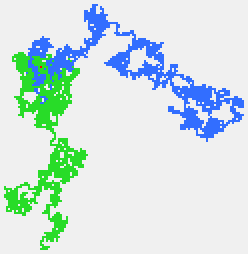

In [23]:
def day3_visualize(s):
  dyx_from_ch = {'>': (0, 1), '<': (0, -1), 'v': (1, 0), '^': (-1, 0)}
  yxs = [(0, 0)] * 2
  mapping = {}

  for index, ch in enumerate(s.strip()):
    dy, dx = dyx_from_ch[ch]
    actor = index % 2
    yxs[actor] = yx = yxs[actor][0] + dy, yxs[actor][1] + dx
    mapping[yx] = (50, 110, 255) if actor == 1 else (40, 220, 40)

  mapping[0, 0] = 255, 0, 0
  image = hh.grid_from_indices(mapping, background=(240,) * 3, pad=2, dtype=np.uint8)
  image = image.repeat(2, axis=0).repeat(2, axis=1)
  media.show_image(image, title='day3')


day3_visualize(puzzle.input)

<a name="day4"></a>
## Day 4: MD5 hash with zeros

- Part 1: Find the lowest positive number (no leading zeroes: 1, 2, 3, ...) that produces such a hexadecimal hash with 5 leading zeros.

- Part 2: Now find one that starts with six zeroes.

In [24]:
puzzle = advent.puzzle(day=4)

For [day 4](https://adventofcode.com/2015/day/4), `puzzle.input` has a single line of 8 characters:

yzbqklnj


The stored answers are: `{1: '282749', 2: '9962624'}`

In [25]:
def day4a(s, *, part2=False):
  prefix = s.strip().encode()
  md5 = _get_md5()
  for index in itertools.count(1):
    digest = md5(prefix + bytes(str(index), 'ascii')).digest()
    if part2:
      if digest[:3] == b'\0\0\0':
        return index
    else:
      if digest[:2] == b'\0\0' and digest.hex()[4] == '0':
        return index


check_eq(day4a('abcdef'), 609043)
check_eq(day4a('pqrstuv'), 1048970)
puzzle.verify(1, day4a)

day4a_part2 = functools.partial(day4a, part2=True)
# puzzle.verify(2, day4a_part2)  # ~3.7 s.

(Part 1: 0.105 s)


In [26]:
# Multiprocessing with partition of index lists into index sublists.
# The call of a function in the current module requires 'fork' and that current is main.
def day4b_test(prefix: bytes, indices: list[int], part2: bool) -> int:
  md5 = _get_md5()
  for index in indices:
    digest = md5(prefix + bytes(str(index), 'ascii')).digest()
    if digest[:3] == b'\0\0\0' if part2 else (digest[:2] == b'\0\0' and digest.hex()[4] == '0'):
      return index
  return 10**9


def day4b(s, *, part2=False, group_size=240_000):
  prefix = s.strip().encode()
  with multiprocessing.Pool() as pool:  # Either 'fork' or 'spawn' is OK.
    for start in itertools.count(1, group_size):
      groups = more_itertools.divide(multiprocessing.cpu_count(), range(start, start + group_size))
      args = [(prefix, list(indices), part2) for indices in groups]
      results: list[int] = pool.starmap(day4b_test, args)
      if min(results) < 10**9:
        return min(results)


# If run inside IPython and multiprocessing will fork (e.g. sys.platform == 'linux'), test this.
if __name__ == '__main__' and multiprocessing.get_start_method() == 'fork':
  check_eq(day4b('abcdef'), 609_043)
  check_eq(day4b('pqrstuv'), 1_048_970)
  puzzle.verify(1, day4b)

  day4b_part2 = functools.partial(day4b, part2=True)
  puzzle.verify(2, day4b_part2)

(Part 1: 0.095 s)
(Part 2: 0.634 s)


In [27]:
# Multiprocessing with partition of index lists into index sublists.
def day4c(s, *, part2=False, group_size=240_000):
  def find_index(prefix: bytes, indices: list[int], part2: bool) -> int:
    md5 = _get_md5()
    for index in indices:
      digest = md5(prefix + bytes(str(index), 'ascii')).digest()
      if digest[:3] == b'\0\0\0' if part2 else (digest[:2] == b'\0\0' and digest.hex()[4] == '0'):
        return index
    return 10**9

  prefix = s.strip().encode()
  header = 'from typing import Any'
  with hh.function_in_temporary_module(find_index, header=header, funcs=[_get_md5]) as function:
    with multiprocessing.Pool() as pool:  # Either 'fork' or 'spawn' is OK.
      for start in itertools.count(1, group_size):
        num_processors = multiprocessing.cpu_count()
        groups = more_itertools.divide(num_processors, range(start, start + group_size))
        args = [(prefix, list(indices), part2) for indices in groups]
        results: list[int] = pool.starmap(function, args)
        if min(results) < 10**9:
          return min(results)


check_eq(day4c('abcdef'), 609_043)
check_eq(day4c('pqrstuv'), 1_048_970)
puzzle.verify(1, day4c)

day4c_part2 = functools.partial(day4c, part2=True)
puzzle.verify(2, day4c_part2)

(Part 1: 0.103 s)
(Part 2: 0.628 s)


In [28]:
# Multiprocessing with partition of index ranges into index subranges.
def day4(s, *, part2=False, group_size=240_000):
  def find_index(prefix: bytes, start: int, stop: int, part2: bool) -> int:
    md5 = _get_md5()
    for index in range(start, stop):
      digest = md5(prefix + bytes(str(index), 'ascii')).digest()
      if digest[:3] == b'\0\0\0' if part2 else (digest[:2] == b'\0\0' and digest.hex()[4] == '0'):
        return index
    return 10**9

  prefix = s.strip().encode()
  header = 'from typing import Any'
  with hh.function_in_temporary_module(find_index, header=header, funcs=[_get_md5]) as function:
    with multiprocessing.Pool() as pool:  # Either 'fork' or 'spawn' is OK.
      chunk_size = math.ceil(group_size / multiprocessing.cpu_count())
      for start in itertools.count(1, group_size):
        group_stop = start + group_size
        args = []
        while start < group_stop:
          stop = min(start + chunk_size, group_stop)
          args.append((prefix, start, stop, part2))
          start = stop
        results: list[int] = pool.starmap(function, args)
        if min(results) < 10**9:
          return min(results)


check_eq(day4('abcdef'), 609_043)
check_eq(day4('pqrstuv'), 1_048_970)
puzzle.verify(1, day4)

day4_part2 = functools.partial(day4, part2=True)
puzzle.verify(2, day4_part2)

(Part 1: 0.088 s)
(Part 2: 0.493 s)


<a name="day5"></a>
## Day 5: Count "nice" strings

- Part 1: How many strings are nice?

- Part 2: How many strings are nice under these new rules?

In [29]:
puzzle = advent.puzzle(day=5)

For [day 5](https://adventofcode.com/2015/day/5), `puzzle.input` has 1_000 lines:

zgsnvdmlfuplrubt
vlhagaovgqjmgvwq
ffumlmqwfcsyqpss
zztdcqzqddaazdjp
eavfzjajkjesnlsb
urrvucyrzzzooxhx
xdwduffwgcptfwad
orbryxwrmvkrsxsr
 ...
sztzziuqroeidcus
pxdfvcpvwaddrzwv
phdqqxleqdjfgfbg
cqfikbgxvjmnfncy


The stored answers are: `{1: '238', 2: '69'}`

In [30]:
def day5_part1(s):
  def is_nice(line: str) -> bool:
    num_vowels = sum(letter in 'aeiou' for letter in line)
    if num_vowels < 3:
      return False
    has_repeated_letter = any(a == b for a, b in itertools.pairwise(line))
    if not has_repeated_letter:
      return False
    if any(s2 in line for s2 in ['ab', 'cd', 'pq', 'xy']):
      return False
    return True

  lines = s.splitlines()
  return sum(1 for line in lines if is_nice(line))


# spellcheck=off
check_eq(day5_part1('ugknbfddgicrmopn'), 1)
check_eq(day5_part1('aaa'), 1)
check_eq(day5_part1('jchzalrnumimnmhp'), 0)
check_eq(day5_part1('haegwjzuvuyypxyu'), 0)
check_eq(day5_part1('dvszwmarrgswjxmb'), 0)
# spellcheck=on
puzzle.verify(1, day5_part1)

(Part 1: 0.001 s)


In [31]:
def day5_part2(s):
  def is_nice(line: str) -> bool:
    if not re.search(r'(..).*\1', line):
      return False
    if not re.search(r'(.).\1', line):
      return False
    return True

  lines = s.splitlines()
  return sum(1 for line in lines if is_nice(line))


# spellcheck=off
check_eq(day5_part2('qjhvhtzxzqqjkmpb'), 1)
check_eq(day5_part2('xxyxx'), 1)
check_eq(day5_part2('uurcxstgmygtbstg'), 0)
check_eq(day5_part2('ieodomkazucvgmuy'), 0)
# spellcheck=on
puzzle.verify(2, day5_part2)

(Part 2: 0.001 s)


<a name="day6"></a>
## Day 6: 2D grid of lights

- Part 1: After following the instructions, how many lights are lit?

- Part 2: What is the total brightness of all lights combined after following Santa's instructions?

In [32]:
puzzle = advent.puzzle(day=6)

For [day 6](https://adventofcode.com/2015/day/6), `puzzle.input` has 300 lines:

turn off 660,55 through 986,197
turn off 341,304 through 638,850
turn off 199,133 through 461,193
toggle 322,558 through 977,958
toggle 537,781 through 687,941
turn on 226,196 through 599,390
turn on 240,129 through 703,297
turn on 317,329 through 451,798
 ...
turn on 715,871 through 722,890
toggle 424,675 through 740,862
toggle 580,592 through 671,900
toggle 296,687 through 906,775


The stored answers are: `{1: '400410', 2: '15343601'}`

In [33]:
def day6_part1(s, *, visualize=False):
  def get_image() -> np.ndarray:
    return hh.to_image(grid[::2, ::2], 245, 0)

  shape = 1000, 1000
  grid = np.full(shape, False)
  lines = s.splitlines()
  images = [get_image()]

  for line in lines:
    groups = hh.re_groups(r'^(.*) (\d+),(\d+) through (\d+),(\d+)$', line)
    operation, y1, x1, y2, x2 = groups[0], *map(int, groups[1:])
    assert y1 <= y2 and x1 <= x2
    window = grid[y1 : y2 + 1, x1 : x2 + 1]
    match operation:
      case 'turn off':
        window[:] = False
      case 'turn on':
        window[:] = True
      case 'toggle':
        window[:] = ~window[:]
      case _:
        raise ValueError(line)
    if visualize:
      images.append(get_image())

  if visualize:
    images = [images[0]] * 40 + images + [images[-1]] * 100
    media.show_video(images, codec='gif', fps=50, title='day6a')

  return grid.sum()


check_eq(day6_part1('turn on 0,0 through 999,999'), 1_000_000)
check_eq(day6_part1('toggle 0,0 through 999,0'), 1000)
check_eq(day6_part1('turn on 499,499 through 500,500'), 4)
check_eq(day6_part1('turn off 499,499 through 500,500'), 0)
puzzle.verify(1, day6_part1)

(Part 1: 0.003 s)


day6a

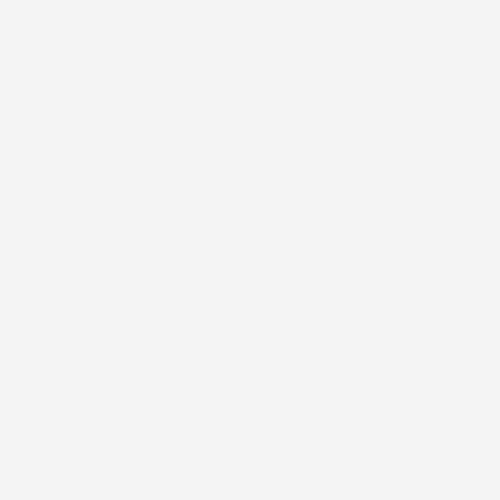

In [34]:
_ = day6_part1(puzzle.input, visualize=True)

In [35]:
def day6_part2(s, *, visualize=False):
  def get_image() -> np.ndarray:
    return 0.97 - grid[::2, ::2] / 45

  shape = 1000, 1000
  grid = np.full(shape, 0, np.int16)
  lines = s.splitlines()
  images = [get_image()]

  for line in lines:
    groups = hh.re_groups(r'^(.*) (\d+),(\d+) through (\d+),(\d+)$', line)
    operation, y1, x1, y2, x2 = groups[0], *map(int, groups[1:])
    assert y1 <= y2 and x1 <= x2
    window = grid[y1 : y2 + 1, x1 : x2 + 1]
    match operation:
      case 'turn off':
        window[:] = np.maximum(window[:] - 1, 0)
      case 'turn on':
        window[:] += 1
      case 'toggle':
        window[:] += 2
      case _:
        raise ValueError(line)
    if visualize:
      images.append(get_image())

  if visualize:
    images = [images[0]] * 40 + images + [images[-1]] * 100
    media.show_video(images, codec='gif', fps=50, title='day6b')

  return grid.sum()


check_eq(day6_part2('turn on 0,0 through 999,999'), 1_000_000)
check_eq(day6_part2('toggle 0,0 through 999,999'), 2_000_000)
puzzle.verify(2, day6_part2)

(Part 2: 0.011 s)


In [36]:
if SHOW_BIG_MEDIA:
  _ = day6_part2(puzzle.input, visualize=True)

Cached result:<br/>
<img src="results/day6b.gif">

<a name="day7"></a>
## Day 7: Graph of operations

- Part 1: What signal is ultimately provided to wire a?

- Part 2: Now, take the signal you got on wire a, override wire b to that signal, and reset the other wires (including wire a). What new signal is ultimately provided to wire a?

In [37]:
puzzle = advent.puzzle(day=7)

For [day 7](https://adventofcode.com/2015/day/7), `puzzle.input` has 339 lines:

af AND ah -> ai
NOT lk -> ll
hz RSHIFT 1 -> is
NOT go -> gp
du OR dt -> dv
x RSHIFT 5 -> aa
at OR az -> ba
eo LSHIFT 15 -> es
 ...
o AND q -> r
NOT p -> q
k AND m -> n
as RSHIFT 2 -> at


The stored answers are: `{1: '956', 2: '40149'}`

In [38]:
s1 = """\
123 -> x
456 -> y
x AND y -> d
x OR y -> e
x LSHIFT 2 -> f
y RSHIFT 2 -> g
NOT x -> h
NOT y -> i
"""

In [39]:
# Note that sympy does not support bitwise logical operations.

In [40]:
def day7(s, *, part2=False, output='a'):
  lines = s.splitlines()

  def sort_lines() -> list[str]:
    graph: dict[str, list[str]] = {}
    for line in lines:
      match line.split():
        case src, '->', dst:
          assert dst not in graph
          graph[dst] = [src]
        case src1, operator, src2, '->', dst:
          del operator
          assert dst not in graph
          graph[dst] = [src1, src2]
        case 'NOT', src, '->', dst:
          assert dst not in graph
          graph[dst] = [src]
        case _:
          raise ValueError(line)

    sorted_nodes = list(graphlib.TopologicalSorter(graph).static_order())
    node_index = {node: index for index, node in enumerate(sorted_nodes)}
    return sorted(lines, key=lambda line: node_index[line.split()[-1]])

  sorted_lines = sort_lines()

  def evaluate() -> int:
    def get_value(src: str) -> int:
      return wires[src] if src.isalpha() else int(src)

    wires = {}
    for line in sorted_lines:
      match line.split():
        case src, '->', dst:
          wires[dst] = get_value(src)
        case src1, operator, src2, '->', dst:
          value1, value2 = get_value(src1), get_value(src2)
          match operator:
            case 'LSHIFT':
              wires[dst] = value1 << value2
            case 'RSHIFT':
              wires[dst] = value1 >> value2
            case 'AND':
              wires[dst] = value1 & value2
            case 'OR':
              wires[dst] = value1 | value2
            case _:
              raise ValueError(operator)
        case 'NOT', src, '->', dst:
          wires[dst] = 65535 - get_value(src)

    return wires[output]

  result = evaluate()

  if part2:
    (index,) = [index for index, line in enumerate(sorted_lines) if line.split()[-1] == 'b']
    sorted_lines[index] = f'{result} -> b'
    result = evaluate()

  return result


check_eq(day7(s1, output='h'), 65412)
puzzle.verify(1, day7)

day7_part2 = functools.partial(day7, part2=True)
puzzle.verify(2, day7_part2)

(Part 1: 0.001 s)
(Part 2: 0.001 s)


day7

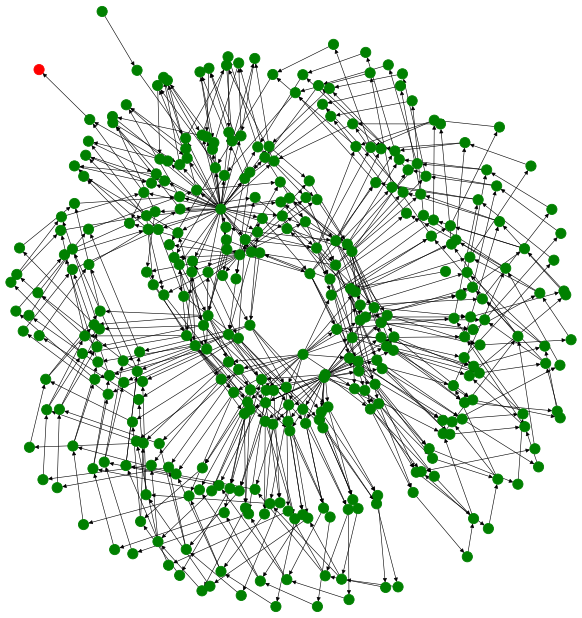

In [41]:
def day7_visualize(s):
  graph = networkx.DiGraph()
  graph.add_node('a', node_color='red')
  for line in s.splitlines():
    match line.split():
      case src, '->', dst:
        graph.add_edge(src, dst)
      case src1, operator, src2, '->', dst:
        del operator
        graph.add_edge(src1, dst)
        graph.add_edge(src2, dst)
      case 'NOT', src, '->', dst:
        graph.add_edge(src, dst)

  pos = hh.graph_layout(graph, prog='neato')
  pos = hh.rotate_layout_so_node_is_on_left(pos, 'a', math.tau / 8)
  fig, ax = plt.subplots(figsize=(12, 12), dpi=60)
  ax.axes.set_aspect('equal')
  node_color = [(attr or 'green') for _, attr in graph.nodes(data='node_color')]
  networkx.draw(graph, pos, node_size=150, node_color=node_color, width=0.7)
  fig.tight_layout(pad=0)
  image = hh.bounding_crop(hh.image_from_plt(fig), (255, 255, 255), margin=5)
  media.show_image(image, border=True, title='day7')
  plt.close(fig)


day7_visualize(puzzle.input)

<a name="day8"></a>
## Day 8: Quoted strings

- Part 1: What is the number of characters of code for string literals minus the number of characters in memory for the values of the strings in total for the entire file?

- Part 2: Encode the strings.  Find the total number of characters to represent the newly encoded strings minus the number of characters of code in each original string literal.

In [42]:
puzzle = advent.puzzle(day=8)

For [day 8](https://adventofcode.com/2015/day/8), `puzzle.input` has 300 lines:

"azlgxdbljwygyttzkfwuxv"
"v\xfb\"lgs\"kvjfywmut\x9cr"
"merxdhj"
"dwz"
"d\\gkbqo\\fwukyxab\"u"
"k\xd4cfixejvkicryipucwurq\x7eq"
"nvtidemacj\"hppfopvpr"
"kbngyfvvsdismznhar\\p\"\"gpryt\"jaeh"
 ...
"x\x6fxbljsjdgd\xaau"
"hjg\\w\"\x78uoqbsdikbjxpip\"w\"jnhzec"
"gk"
"\\zrs\\syur"


The stored answers are: `{1: '1342', 2: '2074'}`

In [43]:
s1 = r"""
""
"abc"
"aaa\"aaa"
"\x27"
"""[
    1:
]

In [44]:
def day8(s, *, part2=False):
  sum_extra_char = 0
  for line in s.splitlines():
    if part2:
      string = '"' + line.replace('\\', r'\\').replace('"', r'\"') + '"'
      sum_extra_char += len(string) - len(line)
    else:
      string = ast.literal_eval(line)
      sum_extra_char += len(line) - len(string)

  return sum_extra_char


check_eq(day8(s1), 12)
puzzle.verify(1, day8)

day8_part2 = functools.partial(day8, part2=True)
check_eq(day8_part2(s1), 19)
puzzle.verify(2, day8_part2)

(Part 1: 0.001 s)
(Part 2: 0.000 s)


<a name="day9"></a>
## Day 9: Hamiltonian path

- Part 1: Find the shortest path visiting all nodes.

- Part 2: Find the longest path visiting all nodes.

In [45]:
puzzle = advent.puzzle(day=9)

For [day 9](https://adventofcode.com/2015/day/9), `puzzle.input` has 28 lines:

AlphaCentauri to Snowdin = 66
AlphaCentauri to Tambi = 28
AlphaCentauri to Faerun = 60
AlphaCentauri to Norrath = 34
AlphaCentauri to Straylight = 34
AlphaCentauri to Tristram = 3
AlphaCentauri to Arbre = 108
Snowdin to Tambi = 22
 ...
Norrath to Arbre = 60
Straylight to Tristram = 27
Straylight to Arbre = 81
Tristram to Arbre = 90


The stored answers are: `{1: '141', 2: '736'}`

In [46]:
s1 = """\
London to Dublin = 464
London to Belfast = 518
Dublin to Belfast = 141
"""

In [47]:
def _permutations_ignoring_reflections(iterable: Iterable[_T]) -> Iterator[tuple[_T, ...]]:
  for permutation in itertools.permutations(iterable):
    if not permutation or permutation[0] <= permutation[-1]:  # type: ignore[operator]
      yield permutation

In [48]:
# Hamiltonian path problem; NP-complete.
def day9(s, *, part2=False):
  graph = collections.defaultdict[str, dict[str, int]](dict)
  for line in s.splitlines():
    node1, node2, s_distance = hh.re_groups(r'(\w+) to (\w+) = (\d+)', line)
    graph[node1][node2] = int(s_distance)
    graph[node2][node1] = int(s_distance)

  def path_length(path: Sequence[str]) -> int:
    return sum(graph[node1][node2] for node1, node2 in itertools.pairwise(path))

  if 1:  # Faster because number is roughly half.
    permutations = _permutations_ignoring_reflections(graph)
  else:
    permutations = itertools.permutations(graph)

  operator = max if part2 else min
  return operator(path_length(path) for path in permutations)


check_eq(day9(s1), 605)
puzzle.verify(1, day9)

day9_part2 = functools.partial(day9, part2=True)
check_eq(day9_part2(s1), 982)
puzzle.verify(2, day9_part2)

(Part 1: 0.016 s)
(Part 2: 0.016 s)


<a name="day10"></a>
## Day 10: Run-length encoding

- Part 1: Starting with the digits in your puzzle input, apply this process 40 times. What is the length of the result?

- Part 2: Apply this process 50 times. What is the length of the new result?

In [49]:
puzzle = advent.puzzle(day=10)

For [day 10](https://adventofcode.com/2015/day/10), `puzzle.input` has a single line of 10 characters:

1113122113


The stored answers are: `{1: '360154', 2: '5103798'}`

In [50]:
def day10a(s, *, num_iterations=40, return_s=False):  # Using string indexing.
  s = s.strip()

  def rle(s: str) -> str:
    result = ''
    index = 0
    while index < len(s):
      ch = s[index]
      index0 = index
      index += 1
      while index < len(s) and s[index] == ch:
        index += 1
      n = index - index0
      assert n < 10
      result += str(n) + ch
    return result

  for _ in range(num_iterations):
    s = rle(s)

  return s if return_s else len(s)


check_eq(day10a('1', num_iterations=1, return_s=True), '11')
check_eq(day10a('11', num_iterations=1, return_s=True), '21')
check_eq(day10a('21', num_iterations=1, return_s=True), '1211')
check_eq(day10a('1211', num_iterations=1, return_s=True), '111221')
check_eq(day10a('111221', num_iterations=1, return_s=True), '312211')
check_eq(day10a('1', num_iterations=5, return_s=True), '312211')
check_eq(day10a('1', num_iterations=5), len('312211'))
puzzle.verify(1, day10a)

day10a_part2 = functools.partial(day10a, num_iterations=50)
# puzzle.verify(2, day10a_part2)  # ~3 s.

(Part 1: 0.200 s)


In [51]:
def day10b(s, *, num_iterations=40, return_s=False):  # Using list[int] indexing.
  array = [int(ch) for ch in s.strip()]

  def rle(array: list[int]) -> list[int]:
    result = []
    index = 0
    while index < len(array):
      value = array[index]
      index0 = index
      index += 1
      while index < len(array) and array[index] == value:
        index += 1
      n = index - index0
      assert n < 10
      result.append(n)
      result.append(value)
    return result

  for _ in range(num_iterations):
    array = rle(array)

  return ''.join(str(value) for value in array) if return_s else len(array)


check_eq(day10b('1', num_iterations=1, return_s=True), '11')
check_eq(day10b('11', num_iterations=1, return_s=True), '21')
check_eq(day10b('21', num_iterations=1, return_s=True), '1211')
check_eq(day10b('1211', num_iterations=1, return_s=True), '111221')
check_eq(day10b('111221', num_iterations=1, return_s=True), '312211')
check_eq(day10b('1', num_iterations=5, return_s=True), '312211')
check_eq(day10b('1', num_iterations=5), len('312211'))
puzzle.verify(1, day10b)

day10b_part2 = functools.partial(day10b, num_iterations=50)
if 0:
  puzzle.verify(2, day10b_part2)  # ~2.1 s.

(Part 1: 0.143 s)


In [52]:
# Using numba with list[int] indexing.
@numba.njit
def day10_process(np_array0: np.ndarray, num_iterations: int) -> int:
  array = list(np_array0)
  for _ in range(num_iterations):
    result = []
    index = 0
    while index < len(array):
      value = array[index]
      index0 = index
      index += 1
      while index < len(array) and array[index] == value:
        index += 1
      n = index - index0
      assert n < 10
      result.append(n)
      result.append(value)
    array = result
  return len(array)


def day10(s, *, num_iterations=40):
  np_array0 = np.array(list(s.strip()), np.int64)
  return day10_process(np_array0, num_iterations)


check_eq(day10('1', num_iterations=5), len('312211'))
puzzle.verify(1, day10)

day10_part2 = functools.partial(day10, num_iterations=50)
puzzle.verify(2, day10_part2)

(Part 1: 0.008 s)
(Part 2: 0.123 s)


<a name="day11"></a>
## Day 11: Next legal password

- Part 1: Given Santa's current password (your puzzle input), what should his next password be?

- Part 2: Santa's password expired again. What's the next one?

In [53]:
puzzle = advent.puzzle(day=11)

For [day 11](https://adventofcode.com/2015/day/11), `puzzle.input` has a single line of 8 characters:

hxbxwxba


The stored answers are: `{1: 'hxbxxyzz', 2: 'hxcaabcc'}`

In [54]:
def day11a(s, *, part2=False):  # Brute-force.
  def map_ch(ch: str) -> int:
    return ord(ch) - ord('a')

  num_advances = 2 if part2 else 1
  state = [map_ch(ch) for ch in s.strip()]
  check_eq(len(state), 8)
  disallowed_values = [map_ch(ch) for ch in 'ilo']
  max_value = map_ch('z')

  def legal_password(state: list[int]) -> bool:
    if not any(a + 2 == b + 1 == c for a, b, c in more_itertools.sliding_window(state, 3)):
      return False
    num_pairs = len(set(a for a, b in itertools.pairwise(state) if a == b))
    if num_pairs < 2:
      return False
    return True

  def consider(state: list[int], start: list[int]) -> list[int] | None:
    assert start
    state2 = state + [0]
    start1 = start[1:]
    start2 = [0] * len(start1)
    for value in range(start[0], max_value + 1):
      if value not in disallowed_values:
        state2[-1] = value
        if not start1:
          if legal_password(state2):
            return state2
        else:
          if result := consider(state2, start1):
            return result
      start1 = start2
    return None

  for _ in range(num_advances):
    state[-1] += 1  # Force an advance.
    state = hh.assert_not_none(consider([], state))

  return ''.join(chr(ord('a') + value) for value in state)


check_eq(day11a('abcdefgh'), 'abcdffaa')
check_eq(day11a('ghijklmn'), 'ghjaabcc')
puzzle.verify(1, day11a)

day11a_part2 = functools.partial(day11a, part2=True)
# puzzle.verify(2, day11a_part2)  # ~0.8 s.

(Part 1: 0.018 s)


In [55]:
def day11(s, *, part2=False):  # Fast early culling.
  def map_ch(ch: str) -> int:
    return ord(ch) - ord('a')

  num_advances = 2 if part2 else 1
  state = [map_ch(ch) for ch in s.strip()]
  check_eq(len(state), 8)
  disallowed_values = [map_ch(ch) for ch in 'ilo']
  max_value = map_ch('z')

  def legal_password(state: list[int]) -> bool:
    return any(a + 2 == b + 1 == c for a, b, c in more_itertools.sliding_window(state, 3))

  def consider(state: list[int], start: list[int]) -> list[int] | None:
    num_pairs = len(set(a for a, b in itertools.pairwise(state) if a == b))
    if num_pairs == 0 and len(state) == 6:
      return None
    need_pair = (num_pairs == 0 and len(state) == 5) or (num_pairs == 1 and len(state) == 7)
    state2 = state + [0]
    start1 = start[1:]
    start2 = [0] * len(start1)
    for value in range(start[0], max_value + 1):
      if value not in disallowed_values and not (need_pair and value != state[-1]):
        state2[-1] = value
        if not start1:
          if legal_password(state2):
            return state2
        elif result := consider(state2, start1):
          return result
      start1 = start2
    return None

  for _ in range(num_advances):
    state[-1] += 1  # Force an advance.
    state = hh.assert_not_none(consider([], state))

  return ''.join(chr(ord('a') + value) for value in state)


check_eq(day11('abcdefgh'), 'abcdffaa')
check_eq(day11('ghijklmn'), 'ghjaabcc')
puzzle.verify(1, day11)

day11_part2 = functools.partial(day11, part2=True)
puzzle.verify(2, day11_part2)

(Part 1: 0.003 s)
(Part 2: 0.012 s)


<a name="day12"></a>
## Day 12: JSON parsing

- Part 1: What is the sum of all numbers in the document?

- Part 2: Ignore any object (and all of its children) which has any property with the value "red". Do this only for objects (`{...}`), not arrays (`[...]`).

In [56]:
puzzle = advent.puzzle(day=12)

For [day 12](https://adventofcode.com/2015/day/12), `puzzle.input` has a single line of 26_663 characters:

{"e":[[{"e":86,"c":23,"a":{"a":[120,169,"green","red","orange"],"b":"red"},"g":" ... 18,"g":"green","f":0,"i":"violet"}}


The stored answers are: `{1: '111754', 2: '65402'}`

In [57]:
def day12a(s, *, part2=False):
  def sum_numbers(expr: Any) -> int:
    match expr:
      case list():
        return sum(sum_numbers(e) for e in expr)
      case dict():
        if part2 and 'red' in expr.values():
          return 0
        return sum(sum_numbers(value) for value in expr.values())
      case int():
        return expr
      case str():
        return 0
      case _:
        raise ValueError(expr)

  return sum_numbers(json.loads(s.strip()))


check_eq(day12a('[1,2,3]'), 6)
check_eq(day12a('{"a":2,"b":4}'), 6)
check_eq(day12a('[[[3]]]'), 3)
check_eq(day12a('{"a":{"b":4},"c":-1}'), 3)
check_eq(day12a('{"a":[-1,1]}'), 0)
check_eq(day12a('[-1,{"a":1}]'), 0)
check_eq(day12a('[]'), 0)
check_eq(day12a('{}'), 0)
puzzle.verify(1, day12a)

day12a_part2 = functools.partial(day12a, part2=True)
check_eq(day12a_part2('[1,2,3]'), 6)
check_eq(day12a_part2('[1,{"c":"red","b":2},3]'), 4)
check_eq(day12a_part2('{"d":"red","e":[1,2,3,4],"f":5}'), 0)
check_eq(day12a_part2('[1,"red",5]'), 6)
puzzle.verify(2, day12a_part2)

(Part 1: 0.001 s)
(Part 2: 0.001 s)


In [58]:
def day12(s, *, part2=False):  # Using "match" statement.
  def sum_numbers(expr: Any) -> int:
    match expr:
      case list():
        return sum(sum_numbers(e) for e in expr)
      case dict():
        if part2 and 'red' in expr.values():
          return 0
        return sum(sum_numbers(value) for value in expr.values())
      case int():
        return expr
      case str():
        return 0
      case x:
        raise AssertionError(x)

  return sum_numbers(json.loads(s.strip()))


check_eq(day12('[1,2,3]'), 6)
check_eq(day12('{"a":2,"b":4}'), 6)
check_eq(day12('[[[3]]]'), 3)
check_eq(day12('{"a":{"b":4},"c":-1}'), 3)
check_eq(day12('{"a":[-1,1]}'), 0)
check_eq(day12('[-1,{"a":1}]'), 0)
check_eq(day12('[]'), 0)
check_eq(day12('{}'), 0)
puzzle.verify(1, day12)

day12_part2 = functools.partial(day12, part2=True)
check_eq(day12_part2('[1,2,3]'), 6)
check_eq(day12_part2('[1,{"c":"red","b":2},3]'), 4)
check_eq(day12_part2('{"d":"red","e":[1,2,3,4],"f":5}'), 0)
check_eq(day12_part2('[1,"red",5]'), 6)
puzzle.verify(2, day12_part2)

(Part 1: 0.001 s)
(Part 2: 0.001 s)


<a name="day13"></a>
## Day 13: Optimal table seating

- Part 1: What is the total change in happiness for the optimal seating arrangement of the actual guest list?

- Part 2: Add yourself to the list, and give all happiness relationships that involve you a score of 0.  What is the total change in happiness for the optimal seating arrangement that actually includes yourself?

In [59]:
puzzle = advent.puzzle(day=13)

For [day 13](https://adventofcode.com/2015/day/13), `puzzle.input` has 56 lines:

Alice would lose 57 happiness units by sitting next to Bob.
Alice would lose 62 happiness units by sitting next to Carol.
Alice would lose 75 happiness units by sitting next to David.
Alice would gain 71 happiness units by sitting next to Eric.
Alice would lose 22 happiness units by sitting next to Frank.
Alice would lose 23 happiness units by sitting next to George.
Alice would lose 76 happiness units by sitting next to Mallory.
Bob would lose 14 happiness units by sitting next to Alice.
 ...
Mallory would gain 44 happiness units by sitting next to David.
Mallory would gain 22 happiness units by sitting next to Eric.
Mallory would gain 79 happiness units by sitting next to Frank.
Mallory would lose 16 happiness units by sitting next to George.


The stored answers are: `{1: '618', 2: '601'}`

In [60]:
s1 = """\
Alice would gain 54 happiness units by sitting next to Bob.
Alice would lose 79 happiness units by sitting next to Carol.
Alice would lose 2 happiness units by sitting next to David.
Bob would gain 83 happiness units by sitting next to Alice.
Bob would lose 7 happiness units by sitting next to Carol.
Bob would lose 63 happiness units by sitting next to David.
Carol would lose 62 happiness units by sitting next to Alice.
Carol would gain 60 happiness units by sitting next to Bob.
Carol would gain 55 happiness units by sitting next to David.
David would gain 46 happiness units by sitting next to Alice.
David would lose 7 happiness units by sitting next to Bob.
David would gain 41 happiness units by sitting next to Carol.
"""

In [61]:
def _permutations_ignoring_cyclic_rotation(iterable: Iterable[_T]) -> Iterator[tuple[_T, ...]]:
  """Return all permutations ignoring cyclic rotations; https://stackoverflow.com/a/76077137"""
  nodes = tuple(iterable)
  if nodes:
    node1, *rest = nodes
    for permutation in itertools.permutations(rest):
      yield node1, *permutation
  else:
    yield ()

In [62]:
def day13(s, *, part2=False):
  nodes = set()
  edges = {}
  for line in s.splitlines():
    pattern = r'^(\w+) would (\w+) (\d+) happiness units by sitting next to (\w+).$'
    node1, effect, delta, node2 = hh.re_groups(pattern, line)
    nodes |= {node1, node2}
    assert (node1, node2) not in edges
    edges[node1, node2] = int(delta) * {'gain': +1, 'lose': -1}[effect]

  if part2:
    for node in nodes:
      edges[node, 'myself'], edges['myself', node] = 0, 0
    nodes.add('myself')

  undirected_edges = {(a, b): edges[a, b] + edges[b, a] for a, b in edges}  # Symmetrize.

  def benefit(ordering: tuple[str, ...]) -> int:
    value = undirected_edges[ordering[-1], ordering[0]]
    for node1, node2 in itertools.pairwise(ordering):
      value += undirected_edges[node1, node2]
    return value

  if 1:  # Faster because smaller set.
    orderings = _permutations_ignoring_cyclic_rotation(nodes)
  else:
    orderings = itertools.permutations(nodes)

  return max(benefit(ordering) for ordering in orderings)


check_eq(day13(s1), 330)
puzzle.verify(1, day13)

day13_part2 = functools.partial(day13, part2=True)
puzzle.verify(2, day13_part2)

(Part 1: 0.005 s)
(Part 2: 0.041 s)


<a name="day14"></a>
## Day 14: Reindeer olympics

- Part 1: Given the descriptions of each reindeer (in your puzzle input), after exactly 2503 seconds, what distance has the winning reindeer traveled?

- Part 2: At the end of each second, he awards one point to the reindeer currently in the lead. (If there are multiple reindeer tied for the lead, they each get one point.)  After exactly 2503 seconds, how many points does the winning reindeer have?

In [63]:
puzzle = advent.puzzle(day=14)

For [day 14](https://adventofcode.com/2015/day/14), `puzzle.input` has 9 lines:

Vixen can fly 19 km/s for 7 seconds, but then must rest for 124 seconds.
Rudolph can fly 3 km/s for 15 seconds, but then must rest for 28 seconds.
Donner can fly 19 km/s for 9 seconds, but then must rest for 164 seconds.
Blitzen can fly 19 km/s for 9 seconds, but then must rest for 158 seconds.
Comet can fly 13 km/s for 7 seconds, but then must rest for 82 seconds.
Cupid can fly 25 km/s for 6 seconds, but then must rest for 145 seconds.
Dasher can fly 14 km/s for 3 seconds, but then must rest for 38 seconds.
Dancer can fly 3 km/s for 16 seconds, but then must rest for 37 seconds.
Prancer can fly 25 km/s for 6 seconds, but then must rest for 143 seconds.


The stored answers are: `{1: '2660', 2: '1256'}`

In [64]:
s1 = """\
Comet can fly 14 km/s for 10 seconds, but then must rest for 127 seconds.
Dancer can fly 16 km/s for 11 seconds, but then must rest for 162 seconds.
"""

In [65]:
def day14(s, *, time=2503, part2=False, visualize=False, part1_closed_form=False):
  @dataclasses.dataclass
  class Reindeer:
    name: str
    speed: int
    interval: int
    rest: int
    distance: int = 0
    score: int = 0

  reindeers: list[Reindeer] = []
  for line in s.splitlines():
    pattern = r'^(\w+) can fly (\d+) km/s for (\d+) seconds, but then must rest for (\d+) seconds.$'
    name, s_speed, s_interval, s_rest = hh.re_groups(pattern, line)
    reindeers.append(Reindeer(name, int(s_speed), int(s_interval), int(s_rest)))

  if part1_closed_form:
    for reindeer in reindeers:
      periods, remainder = divmod(time, reindeer.interval + reindeer.rest)
      motions = periods * reindeer.interval + min(remainder, reindeer.interval)
      reindeer.distance = motions * reindeer.speed
    return max(reindeer.distance for reindeer in reindeers)

  def add_visualized_points(index):
    if visualize:
      max_distance = max(reindeer.distance for reindeer in reindeers)
      for i, reindeer in enumerate(reindeers):
        y, x = divmod(reindeer.distance, 750)
        y2 = y * (len(reindeers) * 3 + 8) + i * 3
        color = (255, 165, 0) if reindeer.distance == max_distance else (255, 0, 0)
        for dy, dx in np.ndindex(3, 3):
          tyxs[index, y2 + dy, x + dx] = color

  tyxs: dict[tuple[int, int, int], tuple[int, int, int]] = {}
  add_visualized_points(0)

  for index in range(time):
    for reindeer in reindeers:
      active = (index % (reindeer.interval + reindeer.rest)) < reindeer.interval
      if active:
        reindeer.distance += reindeer.speed

    if part2:
      max_distance = max(reindeer.distance for reindeer in reindeers)
      for reindeer in reindeers:
        if reindeer.distance == max_distance:
          reindeer.score += 1

    add_visualized_points(index + 1)

  if visualize:
    video: Any = hh.grid_from_indices(tyxs, pad=0, background=(245,) * 3, dtype=np.uint8)
    video = [video[0]] * 50 + list(video) + [video[-1]] * 150
    media.show_video(video, codec='gif', fps=50, title='day14')

  return max((reindeer.score if part2 else reindeer.distance) for reindeer in reindeers)


check_eq(day14(s1, time=1), 16)
check_eq(day14(s1, time=10), 160)
check_eq(day14(s1, time=11), 176)
check_eq(day14(s1, time=12), 176)
check_eq(day14(s1, time=137), 176)
check_eq(day14(s1, time=138), 176)
check_eq(day14(s1, time=1000), 1120)
puzzle.verify(1, day14)

day14_part2 = functools.partial(day14, part2=True)
check_eq(day14_part2(s1, time=1), 1)
check_eq(day14_part2(s1, time=139), 139)
check_eq(day14_part2(s1, time=140), 139)
check_eq(day14_part2(s1, time=1000), 689)
puzzle.verify(2, day14_part2)

(Part 1: 0.003 s)
(Part 2: 0.005 s)


In [66]:
# Faster closed-form solution for Part 1.
day14_part1_closed_form = functools.partial(day14, part1_closed_form=True)
puzzle.verify(1, day14_part1_closed_form)

(Part 1: 0.001 s)


day14

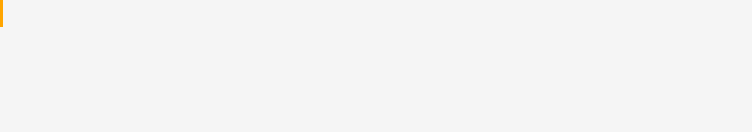

In [67]:
_ = day14(puzzle.input, visualize=True)

<a name="day15"></a>
## Day 15: Best scoring ingredients

- Part 1: Given the ingredients in your kitchen and their properties, what is the total score of the highest-scoring cookie you can make?

- Part 2: Given the ingredients in your kitchen and their properties, what is the total score of the highest-scoring cookie you can make with a calorie total of 500?

In [68]:
puzzle = advent.puzzle(day=15)

For [day 15](https://adventofcode.com/2015/day/15), `puzzle.input` has 4 lines:

Sugar: capacity 3, durability 0, flavor 0, texture -3, calories 2
Sprinkles: capacity -3, durability 3, flavor 0, texture 0, calories 9
Candy: capacity -1, durability 0, flavor 4, texture 0, calories 1
Chocolate: capacity 0, durability 0, flavor -2, texture 2, calories 8


The stored answers are: `{1: '222870', 2: '117936'}`

In [69]:
s1 = """\
Butterscotch: capacity -1, durability -2, flavor 6, texture 3, calories 8
Cinnamon: capacity 2, durability 3, flavor -2, texture -1, calories 3
"""

In [70]:
def day15a(s, *, part2=False, num=100, sum_calories=500):  # Numpy but "for" loop over indices.
  array = np.array([list(map(int, re.findall(r'-?\d+', line))) for line in s.splitlines()])
  max_score = 0
  for index0 in np.ndindex(*[num] * (len(array) - 1)):
    vsum = sum(index0)
    if vsum > num:
      continue
    index = *index0, num - vsum
    sum_properties = array.T @ index
    if part2 and sum_properties[-1] != sum_calories:
      continue
    sum_properties = np.maximum(sum_properties, 0)
    score = np.prod(sum_properties[:-1])  # Ignore calories.
    max_score = max(max_score, score)

  return max_score


check_eq(day15a(s1), 62842880)
puzzle.verify(1, day15a)

day15a_part2 = functools.partial(day15a, part2=True)
check_eq(day15a_part2(s1), 57600000)
puzzle.verify(2, day15a_part2)

(Part 1: 1.077 s)
(Part 2: 0.544 s)


In [71]:
def day15(s, *, part2=False, num=100, sum_calories=500):  # Complete numpy vectorization.
  array = np.array([list(map(int, re.findall(r'-?\d+', line))) for line in s.splitlines()])
  all_indices = np.moveaxis(np.indices([num] * (len(array) - 1)), 0, -1)
  all_indices = all_indices[all_indices.sum(-1) <= num]
  all_indices = np.concatenate((all_indices, num - all_indices.sum(-1, keepdims=True)), axis=-1)
  sum_properties = all_indices @ array
  if part2:
    sum_properties = sum_properties[sum_properties[:, -1] == sum_calories]
  return np.maximum(sum_properties, 0)[:, :-1].prod(axis=-1).max()


check_eq(day15(s1), 62842880)
puzzle.verify(1, day15)

day15_part2 = functools.partial(day15, part2=True)
check_eq(day15_part2(s1), 57600000)
puzzle.verify(2, day15_part2)

(Part 1: 0.020 s)
(Part 2: 0.015 s)


<a name="day16"></a>
## Day 16: Matching partial record

- Part 1: What is the number of the Sue that got you the gift?

- Part 2: The cats and trees readings indicates that there are greater than that many, while the pomeranians and goldfish readings indicate that there are fewer than that many.  What is the number of the real Aunt Sue?

In [72]:
puzzle = advent.puzzle(day=16)

For [day 16](https://adventofcode.com/2015/day/16), `puzzle.input` has 500 lines:

Sue 1: goldfish: 9, cars: 0, samoyeds: 9
Sue 2: perfumes: 5, trees: 8, goldfish: 8
Sue 3: pomeranians: 2, akitas: 1, trees: 5
Sue 4: goldfish: 10, akitas: 2, perfumes: 9
Sue 5: cars: 5, perfumes: 6, akitas: 9
Sue 6: goldfish: 10, cats: 9, cars: 8
Sue 7: trees: 2, samoyeds: 7, goldfish: 10
Sue 8: cars: 8, perfumes: 6, goldfish: 1
 ...
Sue 497: akitas: 8, trees: 2, perfumes: 6
Sue 498: akitas: 1, trees: 1, samoyeds: 4
Sue 499: cars: 0, akitas: 5, vizslas: 3
Sue 500: cats: 2, goldfish: 9, children: 8


The stored answers are: `{1: '40', 2: '241'}`

In [73]:
day16_message = """\
children: 3
cats: 7
samoyeds: 2
pomeranians: 3
akitas: 0
vizslas: 0
goldfish: 5
trees: 3
cars: 2
perfumes: 1
"""

In [74]:
def day16(s, *, part2=False):
  known = {name: int(t) for line in day16_message.splitlines() for name, t in [line.split(': ')]}
  found = []

  def compatible(attribs: dict[str, int]) -> bool:
    for name, value in attribs.items():
      reference = known[name]
      if part2 and name in {'cats', 'trees'}:
        if value <= reference:
          return False
      elif part2 and name in {'pomeranians', 'goldfish'}:
        if value >= reference:
          return False
      elif value != reference:
        return False
    return True

  for line in s.splitlines():
    s_index, s2 = hh.re_groups(r'^Sue (\d+): (.*)$', line)
    attribs = {name: int(t) for s1 in s2.split(', ') for name, t in [s1.split(': ')]}
    if compatible(attribs):
      found.append(int(s_index))

  (index,) = found
  return index


puzzle.verify(1, day16)

day16_part2 = functools.partial(day16, part2=True)
puzzle.verify(2, day16_part2)

(Part 1: 0.002 s)
(Part 2: 0.001 s)


<a name="day17"></a>
## Day 17: Container combinations

- Part 1: Filling all containers entirely, how many different combinations of containers can exactly fit all 150 liters of eggnog?

- Part 2: Find the minimum number of containers that can exactly fit all 150 liters of eggnog. How many different ways can you fill that number of containers and still hold exactly 150 liters?

In [75]:
puzzle = advent.puzzle(day=17)

For [day 17](https://adventofcode.com/2015/day/17), `puzzle.input` has 20 lines:

33
14
18
20
45
35
16
35
 ...
24
41
30
42


The stored answers are: `{1: '1304', 2: '18'}`

In [76]:
s1 = """\
20
15
10
5
5
"""

In [77]:
def day17a_part1(s, *, total=150):  # Early exit by pre-sorting but no memoization.
  sizes = sorted(map(int, s.splitlines()))

  def get_num(sizes: list[int], remaining: int) -> int:
    if remaining == 0:
      return 1
    if not sizes or remaining < sizes[0]:
      return 0
    first, *rest = sizes
    return get_num(rest, remaining) + get_num(rest, remaining - first)

  return get_num(sizes, total)


check_eq(day17a_part1(s1, total=25), 4)
puzzle.verify(1, day17a_part1)

(Part 1: 0.008 s)


In [78]:
def day17_part1(s, *, total=150):  # Fast with memoization.
  sizes = tuple(map(int, s.splitlines()))

  @functools.cache
  def get_num(sizes: tuple[int], remaining: int) -> int:
    if remaining == 0:
      return 1
    if not sizes or remaining < 0:
      return 0
    first, rest = sizes[0], sizes[1:]
    return get_num(rest, remaining) + get_num(rest, remaining - first)

  return get_num(sizes, total)


check_eq(day17_part1(s1, total=25), 4)
puzzle.verify(1, day17_part1)

(Part 1: 0.001 s)


In [79]:
def day17_part2(s, *, total=150):  # Part 2 with memoization.
  sizes = tuple(map(int, s.splitlines()))

  @functools.cache
  def get_min_num(sizes: tuple[int], remaining: int, num: int) -> int:
    if remaining == 0:
      return num
    if remaining < 0 or not sizes:
      return 10**8
    first, rest = sizes[0], sizes[1:]
    return min(get_min_num(rest, remaining, num), get_min_num(rest, remaining - first, num + 1))

  min_num = get_min_num(sizes, total, 0)

  @functools.cache
  def get_num(sizes: tuple[int], remaining: int, num: int) -> int:
    if remaining == 0:
      return 1 if num == min_num else 0
    if remaining < 0 or not sizes:
      return 0
    first, rest = sizes[0], sizes[1:]
    return get_num(rest, remaining, num) + get_num(rest, remaining - first, num + 1)

  return get_num(sizes, total, 0)


check_eq(day17_part2(s1, total=25), 3)
puzzle.verify(2, day17_part2)

(Part 2: 0.005 s)


<a name="day18"></a>
## Day 18: Conway game of life

- Part 1: In your grid of 100x100 lights, given your initial configuration, how many lights are on after 100 steps?

- Part 2: Four lights, one in each corner, are stuck on and can't be turned off.  How many lights are on after 100 steps?

In [80]:
puzzle = advent.puzzle(day=18)

For [day 18](https://adventofcode.com/2015/day/18), `puzzle.input` has 100 lines:

#...##......#......##.##..#...##......##.#.#.###.#.#..#..#......####..#......###.#.#....#..##..###..
####..#.#...#....#.#####.##.##.#..#.......#....#.##...###.###..#.#.#........#..#.#.##...##..#.####.#
...#..##...#.#.###.#.###..#.##.####.###...#...........#.###..##.#.##.#.###...#.#..###....#.###.#..#.
.#...##...####.#..#.....#..#...#.#.##...#...##..#.#.###....#..###.....##..#.###..###.....##..###...#
..##.#####....##..#.#..##.##..######...#..###.######.....#..##...#.#..##..##..#..#..#..##.#.#.#.#...
.###.###.###...##...##..###..##.###.#.....##..##.#.#########...##..##.#..##.#..##..####..#.#.#.#####
#.#####..###.###.##.##.#...#.#.#.#..#.###...#..##.###.#...####.#..#.#.....###..#..####..#.#.#...##..
....#...##.....#....####.##.#.###..#.#.##..#.#...##.###.###..#.##..#.#.##..##..#.##.###..#.#.###.###
 ...
#..#..##.#.##.#.##.#.#.#..###....###.##.#.##.#...#.#..#...#....###.#..#.#.######.#...####..#..##.#.#
#..#.#..#...###.#..##.#...#...##.#......#...#..#..####..##.....#.###...#.#..#.#....#.#

The stored answers are: `{1: '814', 2: '924'}`

In [81]:
s1 = """\
.#.#.#
...##.
#....#
..#...
#.#..#
####..
"""

In [82]:
def day18(s, *, part2=False, num_steps=100, visualize=False):
  def get_image() -> np.ndarray:
    return hh.to_image(grid, 245, 0).repeat(2, axis=0).repeat(2, axis=1)

  grid = np.array([list(line) for line in s.splitlines()]) == '#'
  dyxs = set(itertools.product([-1, 0, 1], repeat=2)) - {(0, 0)}
  maybe_corners = ([0, 0, -1, -1], [0, -1, 0, -1]) if part2 else ([], [])
  grid[maybe_corners] = True
  images = [get_image()]

  for _ in range(num_steps):
    grid2 = np.pad(grid, 1, constant_values=False)
    num_neighbors = np.sum([np.roll(grid2, dyx, (0, 1))[1:-1, 1:-1] for dyx in dyxs], axis=0)
    grid = (num_neighbors == 3) | ((num_neighbors == 2) & grid)
    grid[maybe_corners] = True
    if visualize:
      images.append(get_image())

  if visualize:
    images = [images[0]] * 20 + images + [images[-1]] * 50
    title = f'day18{"b" if part2 else "a"}'
    media.show_video(images, codec='gif', fps=25, title=title)

  return grid.sum()


check_eq(day18(s1, num_steps=4), 4)
puzzle.verify(1, day18)

day18_part2 = functools.partial(day18, part2=True)
check_eq(day18_part2(s1, num_steps=5), 17)
puzzle.verify(2, day18_part2)

(Part 1: 0.015 s)
(Part 2: 0.014 s)


day18a

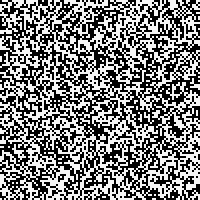

day18b

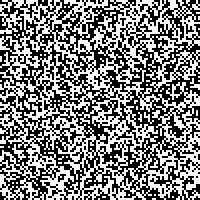

In [83]:
_ = day18(puzzle.input, visualize=True)
_ = day18_part2(puzzle.input, visualize=True)

<a name="day19"></a>
## Day 19: Grammar expansion

- Part 1: How many distinct molecules can be created after all the different ways you can do one replacement on the medicine molecule?

- Part 2: Given the available replacements and the medicine molecule in your puzzle input, what is the fewest number of steps to go from `e` to the medicine molecule?

In [84]:
puzzle = advent.puzzle(day=19)

For [day 19](https://adventofcode.com/2015/day/19), `puzzle.input` has 45 lines:

Al => ThF
Al => ThRnFAr
B => BCa
B => TiB
B => TiRnFAr
Ca => CaCa
Ca => PB
Ca => PRnFAr
 ...
e => NAl
e => OMg

ORnPBPMgArCaCaCaSiThCaCaSiThCaCaPBSiRnFArRnFArCaCaSiThCaCaSiThCaCaCaCaCaCaSiRnFY ... SiRnFArRnCaCaCaFArSiRnFArTiRnPMgArF


The stored answers are: `{1: '576', 2: '207'}`

In [85]:
s1 = """\
H => HO
H => OH
O => HH
"""

In [86]:
# Optionally pre-translate string atoms into single-letter tokens.
def day19_get_input(
    s: str,
    translation: bool = True,
) -> tuple[list[tuple[str, str]], str, Callable[[str], str]]:
  s1, s2 = s.split('\n\n')
  replacements = [(l, r) for line in s1.splitlines() for l, r in [line.split(' => ')]]
  string = s2.strip()
  nodes = sorted(set(re.findall(r'[A-Z][a-z]*|e', s1)))
  relabel = dict(zip(nodes, (chr(ord('A') + i) for i in itertools.count())))

  def translate(s: str) -> str:
    return re.sub(r'[A-Z][a-z]*', lambda m: relabel[m.group(0)], s)

  if translation:
    replacements = [(translate(src), translate(dst)) for src, dst in replacements]
    assert all(len(src) == 1 and (src == 'e' or len(dst) > 1) for src, dst in replacements)
    string = translate(string)

  return replacements, string, translate

In [87]:
def day19a_part1(s):  # Compact.
  replacements, string, _ = day19_get_input(s, translation=False)
  strings = set()
  for index in range(len(string)):
    for src, dst in replacements:
      if string[index:].startswith(src):
        string2 = string[:index] + dst + string[index + len(src) :]
        strings.add(string2)
  return len(strings)


check_eq(day19a_part1(s1 + '\nHOH\n'), 4)
check_eq(day19a_part1(s1 + '\nHOHOHO\n'), 7)
puzzle.verify(1, day19a_part1)

(Part 1: 0.002 s)


In [88]:
def day19_part1(s):  # Use pre-translated strings.
  replacements, string, _ = day19_get_input(s)
  grammar = collections.defaultdict(list)
  for src, dst in replacements:
    grammar[src].append(dst)
  strings = set()
  for index, ch in enumerate(string):
    for dst in grammar[ch]:
      string2 = string[:index] + dst + string[index + 1 :]
      strings.add(string2)
  return len(strings)


check_eq(day19_part1(s1 + '\nHOH\n'), 4)
check_eq(day19_part1(s1 + '\nHOHOHO\n'), 7)
puzzle.verify(1, day19_part1)

(Part 1: 0.001 s)


In [89]:
s2 = """\
e => H
e => O
H => HO
H => OH
O => HH
"""

In [90]:
def day19a_part2(s):  # BFS expansion is completely impractical.
  replacements, desired_string, _ = day19_get_input(s)
  grammar = collections.defaultdict(list)
  for src, dst in replacements:
    grammar[src].append(dst)
  strings = set(['e'])
  for index_expansion in itertools.count():
    strings2 = set()
    for string in strings:
      for index, ch in enumerate(string):
        for dst in grammar[ch]:
          string2 = string[:index] + dst + string[index + 1 :]
          strings2.add(string2)
    strings = strings2
    # hh.show(index_expansion, len(strings))
    if desired_string in strings:
      return index_expansion + 1


check_eq(day19a_part2(s2 + '\nHOH\n'), 3)
check_eq(day19a_part2(s2 + '\nHOHOHO\n'), 6)
# puzzle.verify(2, day19a_part2)
# index_expansion = 7, len(strings) = 793306
# index_expansion = 8, len(strings) = 4933735

In [91]:
def day19b_part2(s):  # BFS simplification is completely impractical.
  replacements, string, _ = day19_get_input(s)
  strings = {string}
  for index_expansion in itertools.count():
    strings2 = set()
    for string in strings:
      for index in range(len(string)):
        for src, dst in replacements:
          if string[index:].startswith(dst):
            string2 = string[:index] + src + string[index + len(dst) :]
            strings2.add(string2)
    strings = strings2
    # hh.show(index_expansion, len(strings))
    if 'e' in strings:
      return index_expansion + 1


check_eq(day19b_part2(s2 + '\nHOH\n'), 3)
check_eq(day19b_part2(s2 + '\nHOHOHO\n'), 6)
# puzzle.verify(2, day19b_part2)
# index_expansion = 0, len(strings) = 107
# index_expansion = 1, len(strings) = 5684
# index_expansion = 2, len(strings) = 199890

In [92]:
def day19c_part2(s):  # Greedy simplification; using original str; prioritize fastest shrinkage.
  replacements, string, _ = day19_get_input(s, translation=True)
  replacements = sorted(replacements, key=lambda pair: len(pair[0]) - len(pair[1]))

  num_steps = 0
  while string != 'e':
    old_string = string
    for src, dst in replacements:
      found = False
      for index in range(len(string)):
        if string[index:].startswith(dst):
          found = True
          string = string[:index] + src + string[index + len(dst) :]
          num_steps += 1
          # print(f'{num_steps=:3} {dst:6}->{src} {string=}')
          break
      if found:
        break
    assert string != old_string, string

  return num_steps


check_eq(day19c_part2(s2 + '\nHOH\n'), 3)
check_eq(day19c_part2(s2 + '\nHOHOHO\n'), 6)
# For my Google profile, it gets stuck: num_steps=201  string='ILCMLELFBPFBFBF'
#   (or 'NRnBSiRnCaRnFArYFArFArF' if translation=False).
# For my GitHub profile, it succeeds.
# puzzle.verify(2, day19c_part2)

In [93]:
# Greedy simplification using multiple random shuffles of rules.  Also add visualization.
def day19e_part2(s, visualize=False):
  def produce_sequence() -> Iterator[tuple[int, list[str]]]:
    for seed in itertools.count():
      replacements, string = replacements0.copy(), string0
      random.seed(seed)
      random.shuffle(replacements)
      replacements = sorted(replacements, key=lambda pair: -len(pair[1]))  # Remove largest first.
      sequence = [string]
      while True:
        for src, dst in replacements:
          if dst in string:
            string = string.replace(dst, src, 1)
            sequence.append(string)
            # print(f'num_steps={len(sequence):3} {dst:6}->{src} {string=}')
            if string == 'e':
              yield seed, sequence
            break
        else:
          break

  @functools.cache
  def random_color(ch: str) -> tuple[int, int, int]:
    random.seed(ch)
    while True:
      color = tuple(random.randrange(256) for _ in range(3))
      if 50 <= sum(color) <= 550:
        return color  # type: ignore

  replacements0, string0, _ = day19_get_input(s)
  seed, sequence = next(produce_sequence())

  if len(replacements0) > 10:
    if visualize:
      image = np.full((len(sequence), len(string0), 3), 245, np.uint8)
      for row, string in enumerate(sequence):
        for col, ch in enumerate(string):
          image[row, col] = random_color(ch)
      image = image.repeat(2, axis=0).repeat(2, axis=1)
      media.show_image(image, title='day19')
    else:
      hh.display_html(f'Solution found on random seed {seed}.')

  return len(sequence) - 1


check_eq(day19e_part2(s2 + '\nHOH\n'), 3)
check_eq(day19e_part2(s2 + '\nHOHOHO\n'), 6)
puzzle.verify(2, day19e_part2)

(Part 2: 0.003 s)


day19

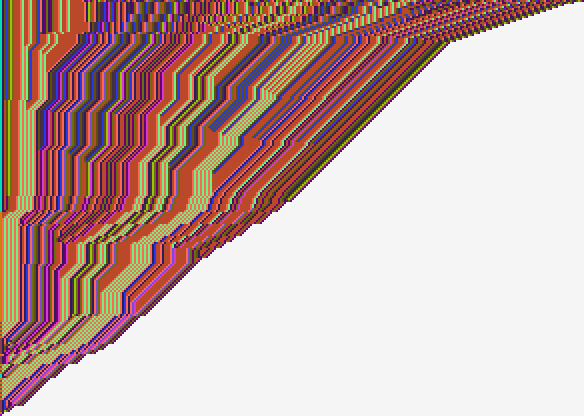

In [94]:
_ = day19e_part2(puzzle.input, visualize=True)

In [95]:
def day19_part2(s):  # Solution specialized for this particular input type.
  _, string, translate = day19_get_input(s)
  # See https://www.reddit.com/r/adventofcode/comments/3xflz8/comment/cy4h7ji/
  # Comment by AoC creator: https://www.reddit.com/r/adventofcode/comments/3xhkeb/comment/cy8mzev
  num_rn, num_ar, num_y = (string.count(translate(node)) for node in ['Rn', 'Ar', 'Y'])
  return len(string) - num_rn - num_ar - 2 * num_y - 1


puzzle.verify(2, day19_part2)

(Part 2: 0.000 s)


In [96]:
# Difficulty in using pyparsing; see https://stackoverflow.com/questions/76133939.
def day19_test_pyparsing1(swap=False):  # Using set_parse_action().
  pp = pyparsing
  Action = enum.Enum('Action', ['SHOW_RULES', 'COMPUTE_SUM'])  # pylint: disable=invalid-name

  for action in Action:

    def parse_rule(rule_name):
      def parse_action(tokens):
        match action:
          case Action.SHOW_RULES:
            return [rule_name, tokens]
          case Action.COMPUTE_SUM:
            return 1 + sum(token for token in tokens if isinstance(token, int))
          case x:
            raise ValueError(x)

      return parse_action

    pp.ParserElement.enable_left_recursion(force=True)
    # e => H; e => O; H => HO; H => OH; O => HH.
    sym_H = pp.Forward()
    sym_O = pp.Forward()
    if swap:
      sym_e = sym_O.copy().set_parse_action(parse_rule('e<-O')) ^ sym_H.copy().set_parse_action(
          parse_rule('e<-H')
      )
    else:
      sym_e = sym_H.copy().set_parse_action(parse_rule('e<-H')) ^ sym_O.copy().set_parse_action(
          parse_rule('e<-O')
      )
    sym_H <<= (
        (sym_H + sym_O).set_parse_action(parse_rule('H<-HO'))
        ^ (sym_O + sym_H).set_parse_action(parse_rule('H<-OH'))
        ^ 'H'
    )
    sym_O <<= (sym_H + sym_H).set_parse_action(parse_rule('O<-HH')) ^ 'O'

    hh.display_html(str(sym_e.parse_string('HOH')))  # Does not parse all unless swap=True.
    hh.display_html(str(sym_e.parse_string('HOHOHO', parse_all=True)))


day19_test_pyparsing1(swap=False)
day19_test_pyparsing1(swap=True)

In [97]:
def day19_test_pyparsing2(swap=False):  # Using Group and count_lists().
  pp = pyparsing
  # e => H; e => O; H => HO; H => OH; O => HH.
  pp.ParserElement.enable_left_recursion(force=True)
  sym_H = pp.Forward()
  sym_O = pp.Forward()
  sym_e = pp.Group(sym_O ^ sym_H) if swap else pp.Group(sym_H ^ sym_O)
  sym_H <<= pp.Group(sym_H + sym_O) ^ pp.Group(sym_O + sym_H) ^ 'H'
  sym_O <<= pp.Group(sym_H + sym_H) ^ 'O'

  def count_lists(expr: Any) -> int:
    return 1 + sum(count_lists(e) for e in expr if not isinstance(e, str))

  def show_result(string: str) -> None:
    result = sym_e.parse_string(string)  # parse_all=True
    hh.display_html(f'{result=!s}, count={count_lists(result) - 1}')

  show_result('HOH')  # Fails to parse the full string using e -> O -> HH -> HOH unless swap=True.
  show_result('HOHOHO')


day19_test_pyparsing2(swap=False)
day19_test_pyparsing2(swap=True)

In [98]:
def day19_test_pyparsing3(s):
  pp = pyparsing
  pp.ParserElement.enable_left_recursion(force=True)
  for seed in range(100):
    try:
      replacements, string, _ = day19_get_input(s)
      random.seed(seed)
      random.shuffle(replacements)
      symbols = set(src for src, dst in replacements)
      parse = {symbol: pp.Forward() for symbol in symbols}
      expression: Any = {symbol: pp.Literal(symbol) for symbol in symbols}
      for src, dst in replacements:
        expr: Any = functools.reduce(operator.add, (parse.get(symbol, symbol) for symbol in dst))
        expression[src] ^= pp.Group(expr)
      for symbol in symbols:
        parse[symbol] <<= expression[symbol]
      result = parse['e'].parse_string(string, parse_all=True)

      def count_lists(expr: Any) -> int:
        return 1 + sum(count_lists(e) for e in expr if not isinstance(e, str))

      count = count_lists(result) - 1
      hh.display_html(f'{seed=} {result=!s} {count=}')
      return count
    except pp.ParseException:
      pass
  hh.display_html('No valid parsing found.')


check_eq(day19_test_pyparsing3(s2 + '\nHOH\n'), 3)
check_eq(day19_test_pyparsing3(s2 + '\nHOHOHO\n'), 6)

# day19_test_pyparsing3(puzzle.input)
# Gets ParseException: ... , found 'LOLFBEKLFBMLEEEM'  (at char 231), (line:1, col:232) so it
# got reasonably far down the string.
# On Google Colab, at seed=7, gets KeyError and infinite recursion.

<a name="day20"></a>
## Day 20: Sum weighted multiples

- Part 1: What is the lowest house number of the house to get at least as many presents as the number in your puzzle input?

- Part 2: Each Elf will stop after delivering presents to 50 houses. To make up for it, they decide to deliver presents equal to eleven times their number at each house.

In [99]:
puzzle = advent.puzzle(day=20)

For [day 20](https://adventofcode.com/2015/day/20), `puzzle.input` has a single line of 8 characters:

33100000


The stored answers are: `{1: '776160', 2: '786240'}`

In [100]:
def day20a_part1(s):  # Slow nested Python loops.
  min_value = int(s.strip())

  def compute_value(house: int) -> int:
    assert house > 0
    value = 0
    for i in range(1, math.isqrt(house) + 1):
      if house % i == 0:
        value += i * 10
        i2 = house // i
        if i2 != i:
          value += i2 * 10
    return value

  check_eq([compute_value(h) for h in range(1, 10)], [10, 30, 40, 70, 60, 120, 80, 150, 130])

  for house in itertools.count(1):
    if compute_value(house) >= min_value:
      return house


if 0:
  puzzle.verify(1, day20a_part1)  # ~13 s.

In [101]:
def day20b(s, *, part2=False, max_house=1_000_000):  # Faster inner loop using numpy.
  min_value = int(s.strip())
  array = np.full(max_house, 0)

  for i in range(1, len(array)):
    if part2:
      array[i : i * 51 : i] += 11 * i
    else:
      array[i::i] += 10 * i

  if not part2:
    check_eq(list(array[1:10]), [10, 30, 40, 70, 60, 120, 80, 150, 130])

  return np.argwhere(array >= min_value)[0][0]


if 0:
  puzzle.verify(1, day20b)  # ~1.2 s.
  day20b_part2 = functools.partial(day20b, part2=True)
  puzzle.verify(2, day20b_part2)  # ~1.2 s.

In [102]:
# As expected, the solutions have many small factors, e.g.:
check_eq(776160, math.prod([2, 2, 2, 2, 2, 3, 3, 5, 7, 7, 11]))
check_eq(786240, math.prod([2, 2, 2, 2, 2, 2, 3, 3, 3, 5, 7, 13]))

In [103]:
# Assume known factors (1.5x speedup) and faster outer loop using numba (30x speedup).
@numba.njit
def day20c_compute(min_value: int, factor: int, part2: bool) -> int:
  max_house = 1_000_000
  array = np.full(max_house // factor, 0)
  if factor > 1:
    for i in range(1, max_house):
      stride = i // math.gcd(i, factor)  # == math.lcm(i, factor) // factor
      if stride == i:  # Index i is coprime with factor, so we can ignore it.
        continue
      if part2:
        array[stride : i * 51 // factor : stride] += 11 * i
      else:
        array[stride::stride] += 10 * i

  else:
    for i in range(1, max_house):
      if part2:
        array[i : i * 51 : i] += 11 * i
      else:
        array[i::i] += 10 * i

  return np.argwhere(array >= min_value)[0][0] * factor


def day20c(s, *, part2=False, assume_factors=True):
  assumed_factors = [2, 2, 2, 2, 3, 3, 5]  # + [2, 7] # no speedup.
  factor = math.prod(assumed_factors) if assume_factors else 1
  return day20c_compute(int(s.strip()), factor, part2)


_ = day20c(puzzle.input)  # For numba compilation.
puzzle.verify(1, day20c)

day20c_part2 = functools.partial(day20c, part2=True)
puzzle.verify(2, day20c_part2)

(Part 1: 0.025 s)
(Part 2: 0.025 s)


In [104]:
def day20d(s, *, part2=False, assume_factors=True):  # Evaluate just multiples of small factors.
  def compute_value(house: int) -> int:
    assert house > 0
    weight = 11 if part2 else 10
    value = 0
    for i in range(1, math.isqrt(house) + 1):
      if house % i == 0:
        i2 = house // i
        if not part2 or i2 <= 50:
          value += i * weight
        if i2 != i:
          if not part2 or i <= 50:
            value += i2 * weight
    return value

  min_value = int(s.strip())
  assumed_factors = [2, 2, 2, 2, 3, 3, 5]
  # assumed_factors += [2, 7]  # Even faster.
  factor = math.prod(assumed_factors) if assume_factors else 1
  for house in itertools.count(factor, factor):
    if compute_value(house) >= min_value:
      return house


puzzle.verify(1, day20d)

day20d_part2 = functools.partial(day20d, part2=True)
puzzle.verify(2, day20d_part2)

(Part 1: 0.023 s)
(Part 2: 0.021 s)


In [105]:
@numba.njit  # Numba version of the above.
def day20_compute_value(house: int, part2: bool) -> int:
  assert house > 0
  weight = 11 if part2 else 10
  value = 0
  for i in range(1, math.floor(house**0.5) + 1):
    if house % i == 0:
      i2 = house // i
      if not part2 or i2 <= 50:
        value += i * weight
      if i2 != i:
        if not part2 or i <= 50:
          value += i2 * weight
  return value


def day20(s, *, part2=False, assume_factors=True):  # Numba version.
  min_value = int(s.strip())
  assumed_factors = [2, 2, 2, 2, 3, 3, 5]
  factor = math.prod(assumed_factors) if assume_factors else 1
  for house in itertools.count(factor, factor):
    if day20_compute_value(house, part2) >= min_value:
      return house


_ = day20(puzzle.input)  # For numba compilation.
puzzle.verify(1, day20)

day20_part2 = functools.partial(day20, part2=True)
puzzle.verify(2, day20_part2)

(Part 1: 0.001 s)
(Part 2: 0.001 s)


<a name="day21"></a>
## Day 21: RPG optimal purchases

- Part 1: You have 100 hit points. The boss's actual stats are in your puzzle input. What is the least amount of gold you can spend and still win the fight?

- Part 2: What is the most amount of gold you can spend and still lose the fight?

In [106]:
puzzle = advent.puzzle(day=21)

For [day 21](https://adventofcode.com/2015/day/21), `puzzle.input` has 3 lines:

Hit Points: 103
Damage: 9
Armor: 2


The stored answers are: `{1: '121', 2: '201'}`

In [107]:
def day21(s, *, part2=False, debug=False):
  @dataclasses.dataclass
  class Character:
    hitpoints: int
    damage: int
    armor: int

  def run_simulation(player: Character, enemy: Character) -> None:
    def attacks(attacker: Character, defender: Character) -> None:
      damage = max(attacker.damage - defender.armor, 1)
      defender.hitpoints -= damage

    while True:
      attacks(player, enemy)
      if enemy.hitpoints <= 0:
        return
      attacks(enemy, player)
      if player.hitpoints <= 0:
        return

  def test_simulation() -> None:
    player = Character(hitpoints=8, damage=5, armor=5)
    enemy = Character(hitpoints=12, damage=7, armor=2)
    run_simulation(player, enemy)
    assert player.hitpoints == 2 and enemy.hitpoints <= 0

  test_simulation()

  def sum_attribs(attribs: Iterable[tuple[int, int, int]]) -> tuple[int, int, int]:
    return tuple(sum(field_values) for field_values in zip(*attribs))  # type: ignore

  # [(cost, damage, armor), ...]
  weapons = [(8, 4, 0), (10, 5, 0), (25, 6, 0), (40, 7, 0), (74, 8, 0)]
  armortypes = [(0, 0, 0), (13, 0, 1), (31, 0, 2), (53, 0, 3), (75, 0, 4), (102, 0, 5)]
  ringtypes = [(25, 1, 0), (50, 2, 0), (100, 3, 0), (20, 0, 1), (40, 0, 2), (80, 0, 3)]
  ring_combos = (
      [sum_attribs(combo) for combo in itertools.combinations(ringtypes, 1)]
      + [sum_attribs(combo) for combo in itertools.combinations(ringtypes, 2)]
      + [(0, 0, 0)]
  )

  enemy = Character(*map(int, re.findall(r'(\d+)', s)))
  best_cost = 0 if part2 else 10**9
  for config in itertools.product(weapons, armortypes, ring_combos):
    weapon, armortype, rings = config
    cost, damage, armor = sum_attribs([weapon, armortype, rings])
    player = Character(hitpoints=100, damage=damage, armor=armor)
    enemy2 = dataclasses.replace(enemy)  # Copy.
    run_simulation(player, enemy2)
    is_win = player.hitpoints > 0
    if (not is_win and cost > best_cost) if part2 else (is_win and cost < best_cost):
      best_cost = cost
      if debug:
        hh.show(weapon, armortype, rings, cost, damage, armor, player.hitpoints)

  return best_cost


puzzle.verify(1, day21)

day21_part2 = functools.partial(day21, part2=True)
puzzle.verify(2, day21_part2)

(Part 1: 0.006 s)
(Part 2: 0.006 s)


<a name="day22"></a>
## Day 22: RPG sequence of spells

- Part 1: You start with 50 hit points and 500 mana points. The boss's actual stats are in your puzzle input. What is the least amount of mana you can spend and still win the fight?

- Part 2: New rule: at the start of each player turn (before any other effects apply), you lose 1 hit point. If this brings you to or below 0 hit points, you lose.

In [108]:
puzzle = advent.puzzle(day=22)

For [day 22](https://adventofcode.com/2015/day/22), `puzzle.input` has 2 lines:

Hit Points: 58
Damage: 9


The stored answers are: `{1: '1269', 2: '1309'}`

In [109]:
def day22(s, *, part2=False, player_hp=50, mana=500):
  boss_hp, boss_damage = map(int, re.findall(r'(\d+)', s))
  min_spent = 10**9

  @functools.cache
  def player_acts(player_hp, mana, spent, boss_hp, time_shield, time_poison, time_recharge):
    nonlocal min_spent
    assert boss_hp > 0 and player_hp > 0
    if part2:
      player_hp -= 1
      if player_hp <= 0:  # Player loses.
        return
    if time_shield > 0:
      time_shield -= 1
    if time_poison > 0:
      time_poison -= 1
      boss_hp -= 3
      if boss_hp <= 0:  # Player wins.
        min_spent = min(min_spent, spent)
        return
    if time_recharge > 0:
      time_recharge -= 1
      mana += 101
    # Explore all 5 possible actions.
    act = boss_acts
    act(player_hp, mana - 53, spent + 53, boss_hp - 4, time_shield, time_poison, time_recharge)
    act(player_hp + 2, mana - 73, spent + 73, boss_hp - 2, time_shield, time_poison, time_recharge)
    if time_shield == 0:
      act(player_hp, mana - 113, spent + 113, boss_hp, 6, time_poison, time_recharge)
    if time_poison == 0:
      act(player_hp, mana - 173, spent + 173, boss_hp, time_shield, 6, time_recharge)
    if time_recharge == 0:
      act(player_hp, mana - 229, spent + 229, boss_hp, time_shield, time_poison, 5)

  def boss_acts(player_hp, mana, spent, boss_hp, time_shield, time_poison, time_recharge):
    nonlocal min_spent
    assert player_hp > 0
    if mana < 0:  # Player cannot do that.
      return
    if spent > min_spent:  # A better solution is already found.
      return
    player_armor = 0
    if time_shield > 0:
      time_shield -= 1
      player_armor = 7
    if time_poison > 0:
      time_poison -= 1
      boss_hp -= 3
    if time_recharge > 0:
      time_recharge -= 1
      mana += 101
    if boss_hp <= 0:  # Player wins.
      min_spent = min(min_spent, spent)
      return
    damage_on_player = max(boss_damage - player_armor, 1)
    player_hp -= damage_on_player
    if player_hp <= 0:  # Player loses.
      return
    player_acts(player_hp, mana, spent, boss_hp, time_shield, time_poison, time_recharge)

  player_acts(player_hp, mana, 0, boss_hp, 0, 0, 0)
  return min_spent


check_eq(day22('13 8', player_hp=10, mana=250), 226)  # 173 + 53
check_eq(day22('14 8', player_hp=10, mana=250), 641)  # 229 + 113 + 73 + 173 + 53
puzzle.verify(1, day22)

day22_part2 = functools.partial(day22, part2=True)
puzzle.verify(2, day22_part2)

(Part 1: 0.007 s)
(Part 2: 0.006 s)


<a name="day23"></a>
## Day 23: Simulate program

- Part 1: What is the value in register b when the program in your puzzle input is finished executing?

- Part 2: What is the value in register b after the program is finished executing if register a starts as 1 instead?

In [110]:
puzzle = advent.puzzle(day=23)

For [day 23](https://adventofcode.com/2015/day/23), `puzzle.input` has 46 lines:

jio a, +16
inc a
inc a
tpl a
tpl a
tpl a
inc a
inc a
 ...
inc a
jmp +2
hlf a
jmp -7


The stored answers are: `{1: '170', 2: '247'}`

In [111]:
s1 = """\
inc b
jio b, +2
tpl b
inc b
"""

In [112]:
def day23(s, *, part2=False):
  lines = s.replace(',', '').splitlines()
  registers = {'a': 1 if part2 else 0, 'b': 0}
  program_counter = 0

  while 0 <= program_counter < len(lines):
    match lines[program_counter].split():
      case 'hlf', register:
        registers[register] //= 2
      case 'tpl', register:
        registers[register] *= 3
      case 'inc', register:
        registers[register] += 1
      case 'jmp', offset:
        program_counter += int(offset) - 1
      case 'jie', register, offset:
        if registers[register] % 2 == 0:
          program_counter += int(offset) - 1
      case 'jio', register, offset:
        if registers[register] == 1:
          program_counter += int(offset) - 1
      case x:
        raise ValueError(x)
    program_counter += 1

  return registers['b']


check_eq(day23(s1), 2)
puzzle.verify(1, day23)

day23_part2 = functools.partial(day23, part2=True)
puzzle.verify(2, day23_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day24"></a>
## Day 24: Bin packing

- Part 1: The packages need to be split into three groups of exactly the same weight.  The first group needs as few packages as possible.  (As a tiebreaker, select this first group as that with smallest product of the weights.)  What is the product of the weights in the first group?

- Part 2: Separate the packages into four groups instead of three.

In [113]:
puzzle = advent.puzzle(day=24)

For [day 24](https://adventofcode.com/2015/day/24), `puzzle.input` has 28 lines:

1
3
5
11
13
17
19
23
 ...
103
107
109
113


The stored answers are: `{1: '11266889531', 2: '77387711'}`

In [114]:
def day24(s, *, part2=False, debug=False):
  weights = sorted(map(int, s.strip().split()))[::-1]  # Let weights have decreasing order.
  # Idea: form the first (smallest) group using elements with large weights (by considering tuples
  # in order of increasing length) and, because there are many small weights, *assume* that it is
  # possible to evenly partition the weights of the remaining elements into the other groups.
  num_groups = 4 if part2 else 3
  desired_total = sum(weights) // num_groups
  if debug:
    hh.show(weights)
    hh.show(len(weights), sum(weights), desired_total)
  large_value = 10**100

  for length in itertools.count(1):
    min_product = large_value

    # Explore adding a next weight starting at index, given current num, total, and product.
    def consider_groups(num, total, product, index):
      nonlocal min_product
      assert num < length and total < desired_total
      # Consider each possible next weight to include into the group.
      for index2 in range(index, len(weights)):
        weight = weights[index2]
        if total + weight * (length - num) < desired_total:
          return
        if total + weight == desired_total:
          assert num + 1 == length
          min_product = min(min_product, product * weight)
          return
        if num + 1 < length and total + weight < desired_total:
          consider_groups(num + 1, total + weight, product * weight, index2 + 1)

    consider_groups(0, 0, 1, 0)
    if min_product < large_value:
      hh.display_html(f'Found a first-group solution containing {length} elements.')
      return min_product


check_eq(day24('1 2 3 4 5 7 8 9 10 11'), 99)
puzzle.verify(1, day24)

day24_part2 = functools.partial(day24, part2=True)
check_eq(day24_part2('1 2 3 4 5 7 8 9 10 11'), 44)
puzzle.verify(2, day24_part2)

(Part 1: 0.002 s)


(Part 2: 0.002 s)


<a name="day25"></a>
## Day 25: Modular exponentiation

- Part 1: What code do you give the machine?

- Part 2: No Part 2 on day 25.

In [115]:
puzzle = advent.puzzle(day=25)

For [day 25](https://adventofcode.com/2015/day/25), `puzzle.input` has a single line of 98 characters:

To continue, please consult the code grid in the manual.  Enter the code at row 2981, column 3075.


The stored answers are: `{1: '9132360', 2: ''}`

In [116]:
# Serial modular exponentiation.
def day25a(s, *, row=None, column=None, initial_value=20_151_125, base=252_533, mod=33_554_393):
  if row is None:
    row, column = map(int, re.findall(r'\d+', s))
  # The index of the last (upper-right) entry on the n'th diagonal is (n) * (n + 1) // 2.
  diagonal = row + column - 1
  last_index = diagonal * (diagonal + 1) // 2
  index = last_index - (row - 1)  # 1_833_1560
  value = initial_value  # At index 1.
  for _ in range(index - 1):
    value = (value * base) % mod
  return value


check_eq(day25a(puzzle.input, row=1, column=1), 20151125)
check_eq(day25a(puzzle.input, row=6, column=1), 33071741)
check_eq(day25a(puzzle.input, row=4, column=6), 31527494)
# puzzle.verify(1, day25a)  # ~0.9 s.

In [117]:
# Memoized recursive modular exponentiation.
def day25b(s, *, row=None, column=None, initial_value=20_151_125, base=252_533, mod=33_554_393):
  if row is None:
    row, column = map(int, re.findall(r'\d+', s))
  # The index of the last (upper-right) entry on the n'th diagonal is (n) * (n + 1) // 2.
  diagonal = row + column - 1
  last_index = diagonal * (diagonal + 1) // 2
  index = last_index - row + 1  # 1_833_1560

  @functools.cache
  def exponentiate(base: int, exponent: int, mod: int) -> int:
    match exponent:
      case 0:
        return 1
      case 1:
        return base
      case _:
        assert exponent > 1
        exponent1, exponent2 = (exponent + 1) // 2, exponent // 2
        return (exponentiate(base, exponent1, mod) * exponentiate(base, exponent2, mod)) % mod

  return (initial_value * exponentiate(base, index - 1, mod)) % mod


check_eq(day25b(puzzle.input, row=1, column=1), 20151125)
check_eq(day25b(puzzle.input, row=6, column=1), 33071741)
check_eq(day25b(puzzle.input, row=4, column=6), 31527494)
puzzle.verify(1, day25b)

(Part 1: 0.000 s)


In [118]:
# Built-in modular exponentiation.
def day25(s, *, row=None, column=None, initial_value=20_151_125, base=252_533, mod=33_554_393):
  if row is None:
    row, column = map(int, re.findall(r'\d+', s))
  diagonal = row + column - 1
  index = diagonal * (diagonal + 1) // 2 - row + 1
  return (initial_value * pow(base, index - 1, mod=mod)) % mod


check_eq(day25(puzzle.input, row=1, column=1), 20151125)
check_eq(day25(puzzle.input, row=6, column=1), 33071741)
check_eq(day25(puzzle.input, row=4, column=6), 31527494)
puzzle.verify(1, day25)

(Part 1: 0.000 s)


In [119]:
puzzle.verify(2, lambda s: '')  # (No "Part 2" on last day.)

(Part 2: 0.000 s)


In [120]:
# You fill the weather machine with fifty stars. It comes to life!
# Snow begins to fall.
# Congratulations! You've finished every puzzle in Advent of Code 2015!
# I hope you had as much fun solving them as I had making them for you.
# I'd love to hear about your adventure;
# you can get in touch with me via contact info on my website or through Twitter.
# If you'd like to see more things like this in the future,
# please consider supporting Advent of Code and sharing it with others.
# To hear about future projects, you can follow me on Twitter.
# I've highlighted the easter eggs in each puzzle, just in case you missed any.
# Hover your mouse over them, and the easter egg will appear.

<a name="timings"></a>
## Timings

In [121]:
advent.show_times()

day_1    part_1: 0.000   part_2: 0.000
day_2    part_1: 0.002   part_2: 0.001
day_3    part_1: 0.001   part_2: 0.002
day_4    part_1: 0.088   part_2: 0.493
day_5    part_1: 0.001   part_2: 0.001
day_6    part_1: 0.003   part_2: 0.011
day_7    part_1: 0.001   part_2: 0.001
day_8    part_1: 0.001   part_2: 0.000
day_9    part_1: 0.016   part_2: 0.016
day_10   part_1: 0.008   part_2: 0.123
day_11   part_1: 0.003   part_2: 0.012
day_12   part_1: 0.001   part_2: 0.001
day_13   part_1: 0.005   part_2: 0.041
day_14   part_1: 0.001   part_2: 0.005
day_15   part_1: 0.020   part_2: 0.015
day_16   part_1: 0.002   part_2: 0.001
day_17   part_1: 0.001   part_2: 0.005
day_18   part_1: 0.015   part_2: 0.014
day_19   part_1: 0.001   part_2: 0.000
day_20   part_1: 0.001   part_2: 0.001
day_21   part_1: 0.006   part_2: 0.006
day_22   part_1: 0.007   part_2: 0.006
day_23   part_1: 0.000   part_2: 0.000
day_24   part_1: 0.002   part_2: 0.002
day_25   part_1: 0.000   part_2: 0.000
Total time:  0.945 s


In [122]:
if 0:  # Compute min execution times over several calls.
  advent.show_times(recompute=True, repeat=3)

In [123]:
if 1:  # Look for unwanted pollution of namespace.
  for _name in globals().copy():
    if not (re.match(r'^(_.*|(day|Day)\d+.*|s\d+|puzzle)$', _name) or _name in _ORIGINAL_GLOBALS):
      print(_name)

In [124]:
if 0:  # Lint.
  hh.run('echo autopep8; autopep8 -j8 -d .')
  hh.run('echo pyink; pyink --diff .')
  hh.run('echo mypy; mypy . || true')
  hh.run('echo pylint; pylint -j8 . || true')
  hh.run(
      'echo flake8; flake8 --indent-size=2 --exclude .ipynb_checkpoints'
      ' --extend-ignore E129,E203,E302,E305,E501,E741'
  )

In [125]:
hh.show_notebook_cell_top_times()

# Total time: 25.14 s
# In[ 67] _ = day14(puzzle.input, visualize=True)                      7.028 s
# In[ 34] _ = day6_part1(puzzle.input, visualize=True)                 2.881 s
# In[ 70] def day15a(s, *, part2=False, num=100, sum_calories=500):    1.754 s
# In[ 41] def day7_visualize(s):\n  graph = networkx.DiGraph()\n       1.678 s
# In[103] # Assume known factors (1.5x speedup) and faster outer       1.299 s
# In[ 27] # Multiprocessing with partition of index lists into index   1.120 s
# In[ 26] # Multiprocessing with partition of index lists into index   1.112 s
# In[ 28] # Multiprocessing with partition of index ranges into        0.903 s
# In[ 25] def day4a(s, *, part2=False):\n  prefix = s.strip().encode(  0.775 s
# In[ 52] # Using numba with list[int] indexing.\n@numba.njit\ndef     0.697 s
# In[ 83] _ = day18(puzzle.input, visualize=True)\n_ = day18_part2(    0.568 s
# In[ 50] def day10a(s, *, num_iterations=40, return_s=False):  #      0.258 s
# In[105] @numba.njit  # Numba

# End

<!-- For Emacs:
Local Variables:
fill-column: 100
End:
-->